In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2024-11-10 10:22:18.262984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 10:22:18.494153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731205338.580209   15932 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731205338.609884   15932 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 10:22:18.824672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Data

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(x_train_set, y_train_set), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# 后面會進行比對，所以要配合tensorflow格式轉成float32
x_train_set = x_train_set.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

### (check data)

In [4]:
x_train_set.shape, y_train_set.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

7


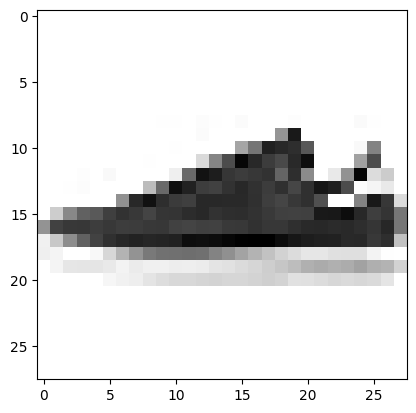

In [5]:
i = 6
print(y_train_set[i])
plt.imshow(x_train_set[i], cmap="binary")
plt.show()

### Split data

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_set, y_train_set, test_size=0.1, random_state=1
)

In [7]:
x_train.shape, x_valid.shape

((54000, 28, 28), (6000, 28, 28))

## 1. GAN
### 1.1 Build model

In [8]:
tf.random.set_seed(1)
np.random.seed(1)
d = 30  # Codeing數量

In [9]:
generator = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[d]),
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)
discriminator = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
gan = keras.models.Sequential([generator, discriminator])

/home/chesterxalan/github/Classwork/Classwork-PythonDLApplicationDevelopment/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731220333.543933   15932 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/chesterxalan/github/Classwork/Classwork-PythonDLApplicationDevelopment/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

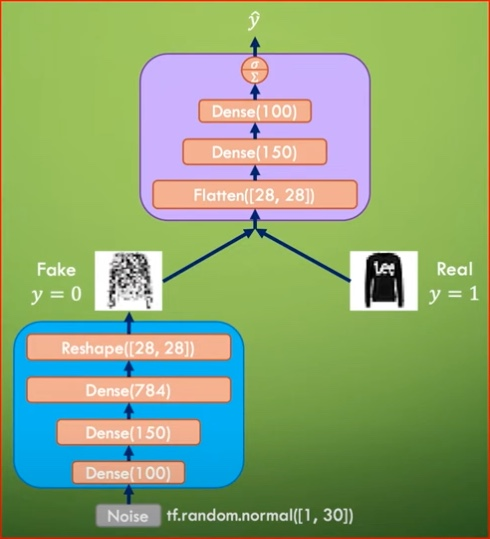

In [10]:
from IPython.display import Image

Image("./img/5.4.1-01.jpeg", width=300)

In [11]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        15,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       118,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,634 (533.73 KB)

 Trainable params: 136,634 (533.73 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │       117,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,951 (519.34 KB)

 Trainable params: 132,951 (519.34 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 28, 28)         │       136,634 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       132,951 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,585 (1.03 MB)

 Trainable params: 269,585 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

### 1.2. Compile

In [14]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

discriminator.trainable = False

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### 1.3 Train

In [15]:
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(x_train)  # 先暫存到暫存區，讀取效率較好
dataset = dataset.shuffle(1000)  # 打亂后取1000筆

# drop_remainder：將剩下的踢除
# prefetch(1)：預先準備下一批次data
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [16]:
def plot_multiple_images(images, n=None):
    # 判斷最后一維度若為 1，則消去最后一維度
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n, 1))

    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap="binary")
        plt.axis("off")
    plt.show()

In [17]:
def train_gan(gan, dataset, batch_size, d, n_epochs=10):
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))

        for x_batch in dataset:
            # 第一階段
            noise = tf.random.normal(shape=[batch_size, d])
            generated_images = generator(noise)
            # 訓練X==>真+假資料
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
            # 訓練Y==>前 32筆設定為 0， 后 32筆設定為 1
            y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)  # 不可用fit(),並進行比較

            # 第二階段
            noise = tf.random.normal(shape=[batch_size, d])
            # 32筆設定為 1
            y2 = tf.constant([[1.0]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        plot_multiple_images(generated_images, 10)  # 生成 10張圖

In [18]:
train_gan(gan, dataset, batch_size, d, n_epochs=10)

Epoch 1/10


AttributeError: 'NoneType' object has no attribute 'update_state'

### 1.4 Generate

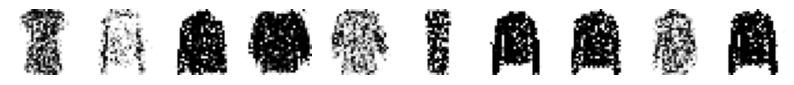

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

noise = tf.random.normal(shape=[10, d])
generated_images = generator(noise)
plot_multiple_images(generated_images, 10)

## 2. Deep Convolutional GAN
### 2.1 Build model

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)
d = 100

In [ ]:
generator = keras.models.Sequential(
    [
        keras.layers.Dense(7 * 7 * 128, input_shape=[d]),
        keras.layers.Reshape([7, 7, 128]),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(
            64, kernel_size=5, strides=2, padding="SAME", activation="selu"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(
            1, kernel_size=5, strides=2, padding="SAME", activation="tanh"
        ),  # 輸出：-1～1
    ]
)
discriminator = keras.models.Sequential(
    [
        keras.layers.Conv2D(
            64,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.layers.LeakyReLU(0.2),
            input_shape=[28, 28, 1],
        ),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(
            128,
            kernel_size=5,
            strides=2,
            padding="SAME",
            activation=keras.layers.LeakyReLU(0.2),
        ),
        keras.layers.Dropout(0.4),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
gan = keras.models.Sequential([generator, discriminator])

### 2.2 Compile

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

discriminator.trainable = False

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### 2.3 Train

In [ ]:
# 增加維度 ，並將原值轉成 -1～1之間
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2.0 - 1.0

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/20


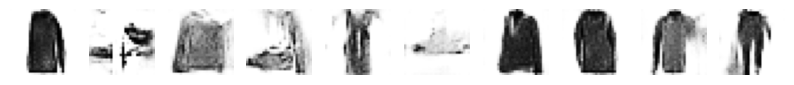

Epoch 2/20


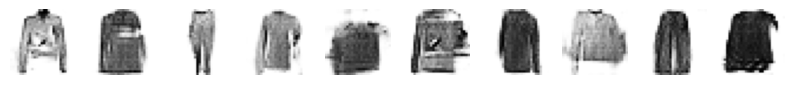

Epoch 3/20


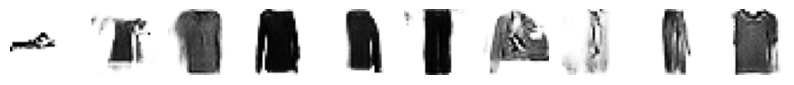

Epoch 4/20


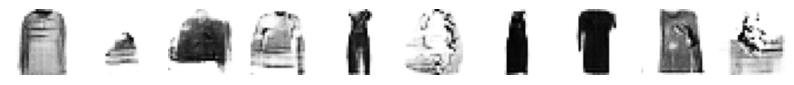

Epoch 5/20


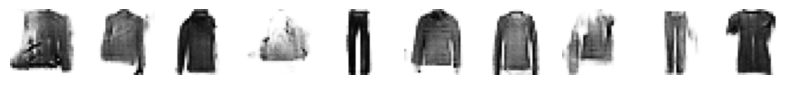

Epoch 6/20


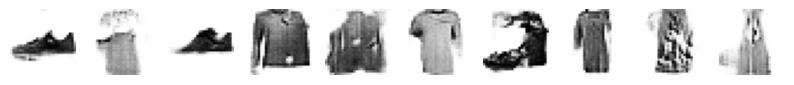

Epoch 7/20


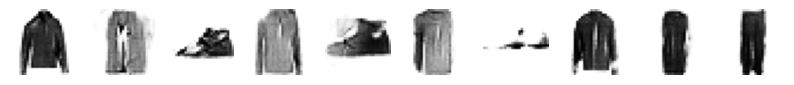

Epoch 8/20


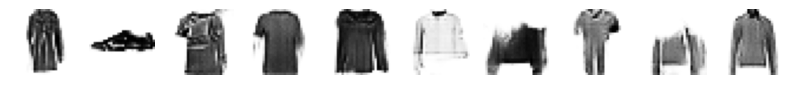

Epoch 9/20


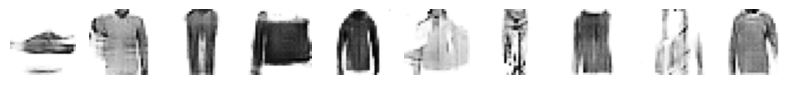

Epoch 10/20


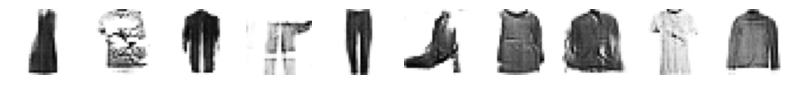

Epoch 11/20


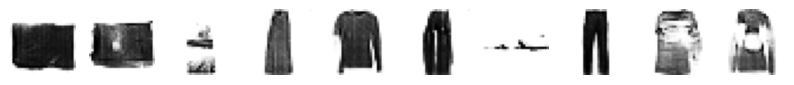

Epoch 12/20


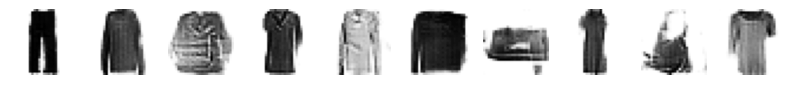

Epoch 13/20


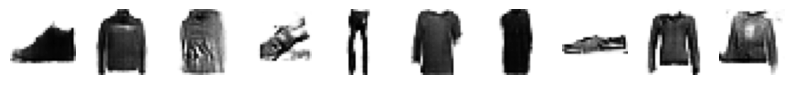

Epoch 14/20


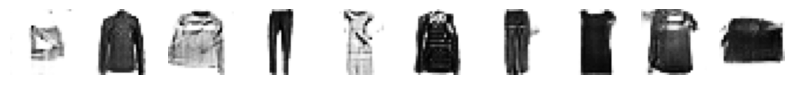

Epoch 15/20


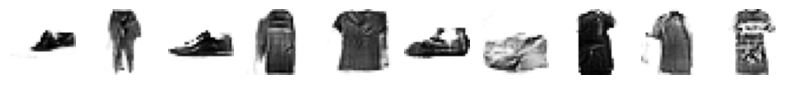

Epoch 16/20


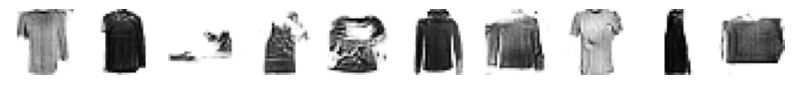

Epoch 17/20


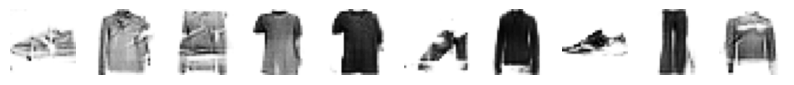

Epoch 18/20


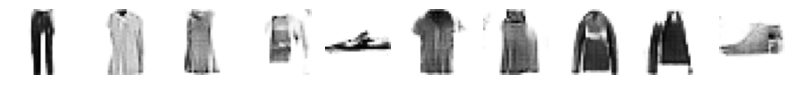

Epoch 19/20


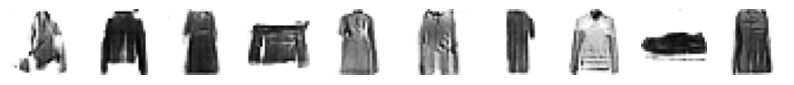

Epoch 20/20


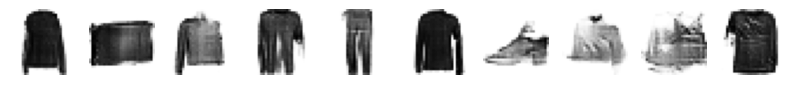

In [ ]:
train_gan(gan, dataset, batch_size, d, n_epochs=20)


### 2.4 Generate

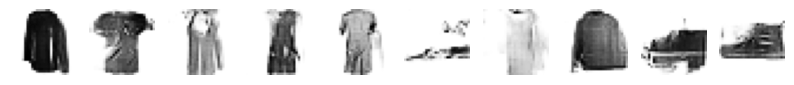

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

noise = tf.random.normal(shape=[10, d])
generated_images = generator(noise)
plot_multiple_images(generated_images, 10)